In [11]:
import numpy as np
import os
import pandas as pd
from matplotlib.colors import LogNorm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
from read_HiC import name_chromosomes

import sys
path='/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/'
sys.path.append(path)

from plotting_tools import set_layout
from genome_topology import normalize_psc
from genome_topology import get_matrix
from genome_topology import fractal_dimension
from genome_topology import make_graph

In [12]:
current_path = os.getcwd()
print("Current working directory:", current_path)
new_path = '/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D'
os.chdir(new_path)
print("Changed working directory to:", new_path)

Current working directory: /Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D
Changed working directory to: /Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D


## CIRCUIT TOPOLOGY ANALISIS OF CHROMOSOME FROM SINGLE CELL Hi-C CONTACT LISTS

This notebook processes single cell Hi-C contact lists (in txt format) to extract topological parameters such as:
- CT parameters (percentage of series, parallel and cross, number of contacts) 
- Network clustering coefficient
- Fractal dimension (calculated over the CT topology matrix)

Load contact pair data file. Each file contains contacts from one cell.

In [13]:
n_all_chr=23 #human
chr_vec=name_chromosomes(n_all_chr)
save_data= True
save_matrix= True
plot_matrix=True

Set path for printing results

Calculate topological parameters looping over all chromosomes in a cell

In [14]:
P=np.zeros(n_all_chr)
S=np.zeros(n_all_chr)
X=np.zeros(n_all_chr)
Dim_fractal = np.zeros(n_all_chr)
clustering = np.zeros(n_all_chr)
r2_fractalfit = np.zeros(n_all_chr)
N_contacts=np.zeros(n_all_chr)

In [15]:
import os
data_dir = 'data'

# Get the names of all files in the 'data' directory that start with 'GSM6081054_Cell_ID_' and end with '.contact'
file_names = [f for f in os.listdir(data_dir) if f.startswith('GSM') and f.endswith('.contact.txt')]
file_names

['GSM6081067_Cell_ID_14.contact.txt',
 'GSM6081065_Cell_ID_12.contact.txt',
 'GSM6081064_Cell_ID_11.contact.txt',
 'GSM6081072_Cell_ID_19.contact.txt',
 'GSM6081077_Cell_ID_24.contact.txt',
 'GSM6081075_Cell_ID_22.contact.txt',
 'GSM6081074_Cell_ID_21.contact.txt',
 'GSM6081061_Cell_ID_08.contact.txt',
 'GSM6081057_Cell_ID_04.contact.txt',
 'GSM6081055_Cell_ID_02.contact.txt',
 'GSM6081054_Cell_ID_01.contact.txt',
 'GSM6081060_Cell_ID_07.contact.txt',
 'GSM6081059_Cell_ID_06.contact.txt',
 'GSM6081058_Cell_ID_05.contact.txt',
 'GSM6081063_Cell_ID_10.contact.txt',
 'GSM6081066_Cell_ID_13.contact.txt',
 'GSM6081076_Cell_ID_23.contact.txt',
 'GSM6081071_Cell_ID_18.contact.txt',
 'GSM6081062_Cell_ID_09.contact.txt',
 'GSM6081069_Cell_ID_16.contact.txt',
 'GSM6081068_Cell_ID_15.contact.txt',
 'GSM6081073_Cell_ID_20.contact.txt',
 'GSM6081056_Cell_ID_03.contact.txt',
 'GSM6081070_Cell_ID_17.contact.txt']

In [17]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import PIL
import matplotlib.pyplot as plt


data_dir = 'data'
file_names = [f for f in os.listdir(data_dir) if f.startswith('GSM') and f.endswith('.contact.txt')]
all_results = []

# Loop through file names
for file in file_names:
    print("Processing the",file[11:21])
    
    file_path = os.path.join(data_dir, file)

    # read data
    contacts = pd.read_csv(file_path, sep='\t')

    # extract cell ID
    cell = file[11:21]
    path_savematrix = 'results/matrices/{}'.format(cell)
    path_savedata = 'results/CT parameters'

    
    N_contacts = np.zeros(len(chr_vec))
    P = np.zeros(len(chr_vec))
    S = np.zeros(len(chr_vec))
    X = np.zeros(len(chr_vec))
    Dim_fractal = np.zeros(len(chr_vec))
    clustering = np.zeros(len(chr_vec))
    r2_fractalfit = np.zeros(len(chr_vec))

    
    chromosome_info = {'chromosome': [], 'start_position': [], 'end_position': [], 'Parallel (%)': [], 'Series (%)': [], 'Cross (%)': []}

    # Loop through chromosomes
    for t, chrom in enumerate(chr_vec):
        print("Processing chromosome",chrom)
        contacts_chr = contacts[(contacts['chr_A'] == chrom) & (contacts['chr_B'] == chrom)]
        index = [contacts_chr['pos_A'], contacts_chr['pos_B']]
        index = np.array(index)
        index = np.transpose(index)
        N_contacts[t] = len(index)

        mat, psc = get_matrix(index, chrom)
        P[t], S[t], X[t] = normalize_psc(psc, N_contacts[t])
        Dim_fractal[t], r2_fractalfit[t] = fractal_dimension(mat, plot_fig=0)
        G = make_graph(index)
        clustering[t] = nx.average_clustering(G)



        if plot_matrix:
            plt.figure(figsize=(5, 5))
            plt.imshow(mat)
            plt.title('{}_{}'.format(cell, chrom))
            plt.savefig('./results/figures/scCT_{}_{}.pdf'.format(cell, chrom))

        if save_matrix:
            os.makedirs(path_savematrix, exist_ok=True)
            PIL.Image.fromarray(mat.astype(float)).save("{}/top_matrix_{}_{}.tif".format(path_savematrix, cell, chrom))
            plt.close()

        # Save results
        if save_data:
            os.makedirs(path_savedata, exist_ok=True)
            topology_parameters = {'Parallel (%)': P, 
                                   'Series (%)': S, 
                                   'Cross (%)': X,
                                   'chromosome': chrom, 
                                   'N contacts': N_contacts, 
                                   'Fractal dimension': Dim_fractal,
                                   'r squared': r2_fractalfit, 
                                   'Clustering': clustering}

            topology_parameters = pd.DataFrame(topology_parameters)

            topology_parameters.to_csv('{}/Top_parameters_{}.csv'.format(path_savedata, cell))



    # 创建包含样本名的 DataFrame
    topology_parameters = {
        'Sample': [cell] * len(chr_vec),  # 添加样本名列
        'chromosome': chrom, 
        'Parallel (%)': P,
        'Series (%)': S,
        'Cross (%)': X,
        'N contacts': N_contacts,
        'Fractal dimension': Dim_fractal,
        'r squared': r2_fractalfit,
        'Clustering': clustering
    }

    all_results.append({
        'cell': cell,
        'topology_parameters': pd.DataFrame(topology_parameters)
    })


Processing the Cell_ID_14
Processing chromosome chr1
Processing chromosome chr2
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8
Processing chromosome chr9
Processing chromosome chr10
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing chromosome chr14
Processing chromosome chr15
Processing chromosome chr16
Processing chromosome chr17
Processing chromosome chr18
Processing chromosome chr19
Processing chromosome chr20
Processing chromosome chr21
Processing chromosome chr22
Processing chromosome chrX
Processing the Cell_ID_12
Processing chromosome chr1
Processing chromosome chr2
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8
Processing chromosome chr9
Processing chromosome chr10
Processing chromosome chr11
Processing chro

/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:425: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:447: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:459: RuntimeWarning: divide by zero encountered in scalar divide
  results['determination'] = ssreg / sstot
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:425: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:447: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_to

Processing chromosome chr22
Processing chromosome chrX
Processing the Cell_ID_20
Processing chromosome chr1
Processing chromosome chr2
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8
Processing chromosome chr9
Processing chromosome chr10
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing chromosome chr14
Processing chromosome chr15
Processing chromosome chr16
Processing chromosome chr17
Processing chromosome chr18
Processing chromosome chr19
Processing chromosome chr20
Processing chromosome chr21
Processing chromosome chr22
Processing chromosome chrX
Processing the Cell_ID_03
Processing chromosome chr1


/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:425: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:447: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:459: RuntimeWarning: divide by zero encountered in scalar divide
  results['determination'] = ssreg / sstot
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:425: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:447: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_to

Processing chromosome chr2
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8
Processing chromosome chr9
Processing chromosome chr10
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing chromosome chr14
Processing chromosome chr15
Processing chromosome chr16
Processing chromosome chr17
Processing chromosome chr18
Processing chromosome chr19
Processing chromosome chr20
Processing chromosome chr21
Processing chromosome chr22
Processing chromosome chrX
Processing the Cell_ID_17
Processing chromosome chr1
Processing chromosome chr2
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8
Processing chromosome chr9
Processing chromosome chr10
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing c

/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:425: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:447: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:459: RuntimeWarning: divide by zero encountered in scalar divide
  results['determination'] = ssreg / sstot
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:425: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:447: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_to

In [18]:
# Combine all results into a single dataframe
all_results_df = pd.concat([result['topology_parameters'] for result in all_results], ignore_index=True)

# Save the combined DataFrame to a CSV file
all_results_df.to_csv('{}/All_Top_parameters.csv'.format(path_savedata))


Processing the Cell_ID_14
Processing chromosome chr10
Processing chromosome chr1
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing chromosome chr14
Processing chromosome chr15
Processing chromosome chr16
Processing chromosome chr17
Processing chromosome chr18
Processing chromosome chr19
Processing chromosome chr20
Processing chromosome chr2
Processing chromosome chr21
Processing chromosome chr22
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8


/var/folders/dp/dd_rnstn2flf9syvmjtgd7400000gn/T/ipykernel_10567/3915102695.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


Processing chromosome chr9
Processing chromosome chrX
Processing the Cell_ID_12
Processing chromosome chr10
Processing chromosome chr1
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing chromosome chr14
Processing chromosome chr15
Processing chromosome chr16
Processing chromosome chr17
Processing chromosome chr18
Processing chromosome chr19
Processing chromosome chr20
Processing chromosome chr2
Processing chromosome chr21
Processing chromosome chr22
Processing chromosome chr3
Processing chromosome chr4
Processing chromosome chr5
Processing chromosome chr6
Processing chromosome chr7
Processing chromosome chr8
Processing chromosome chr9
Processing chromosome chrX
Processing the Cell_ID_11
Processing chromosome chr10
Processing chromosome chr1
Processing chromosome chr11
Processing chromosome chr12
Processing chromosome chr13
Processing chromosome chr14
Processing chromosome chr15
Processing chromosome chr16
Processing chromosome chr17
Processin

/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:162: RuntimeWarning: invalid value encountered in scalar divide
  p = psc[1]/half_mat
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:163: RuntimeWarning: invalid value encountered in scalar divide
  s = psc[2]/half_mat
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:164: RuntimeWarning: invalid value encountered in scalar divide
  x = psc[3]/half_mat
/Users/jialechen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jialechen/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jialechen/Desktop/PhD/CT/Pang_2022_GenomeBiol_3D/functions/genome_topology.py:409: RuntimeWarning: divide by zero encountere

OverflowError: cannot convert float infinity to integer

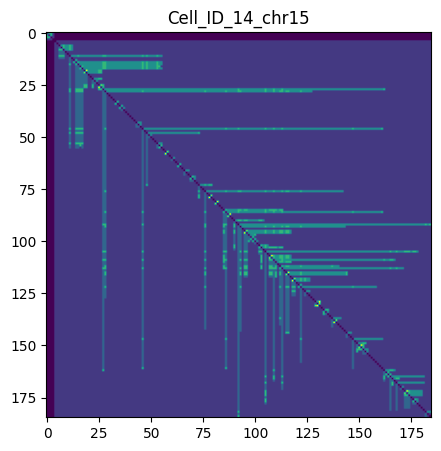

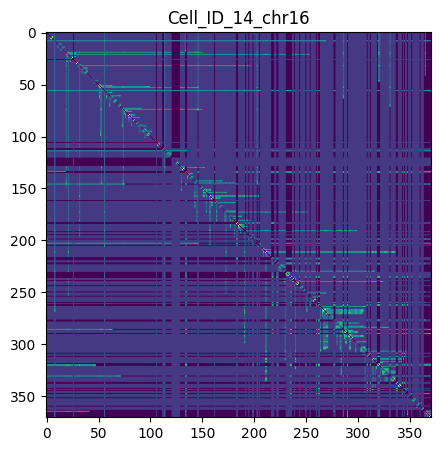

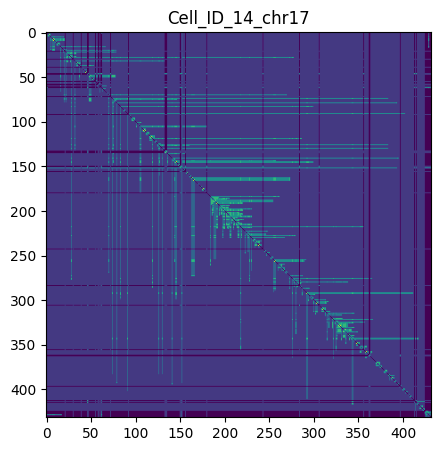

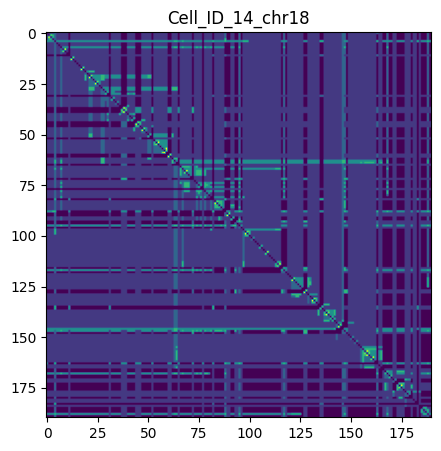

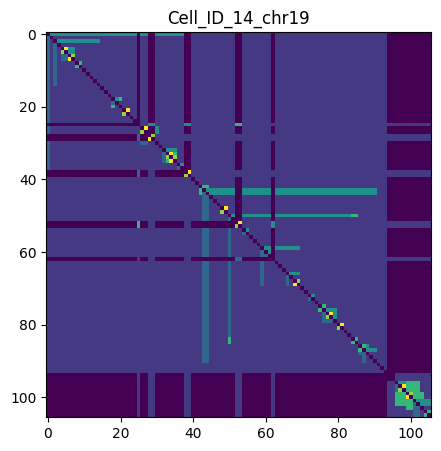

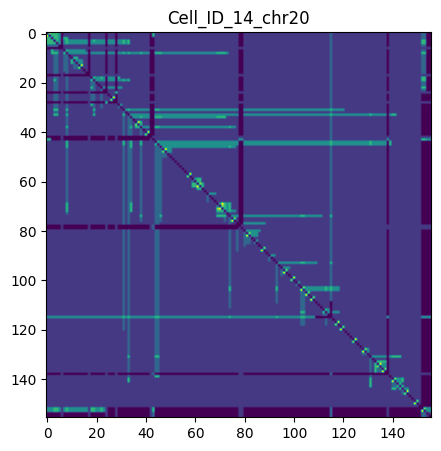

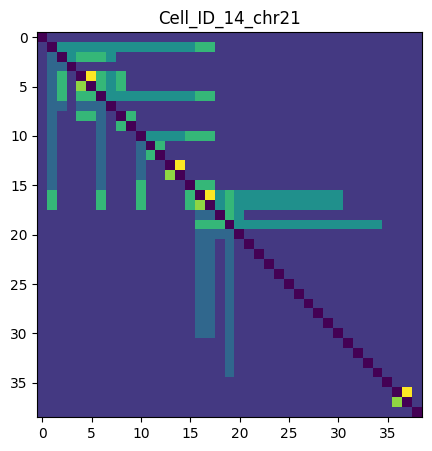

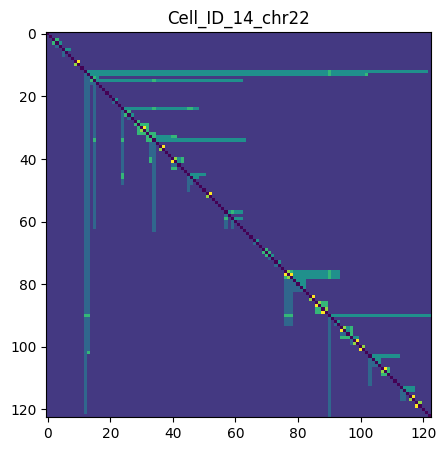

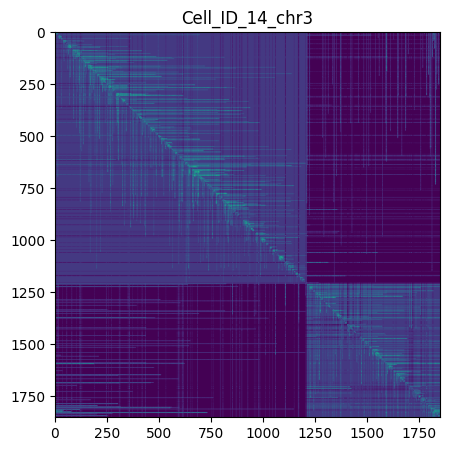

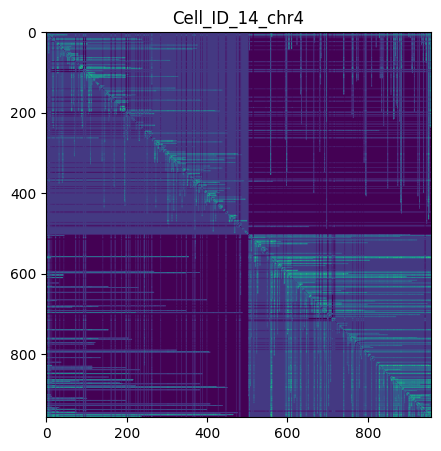

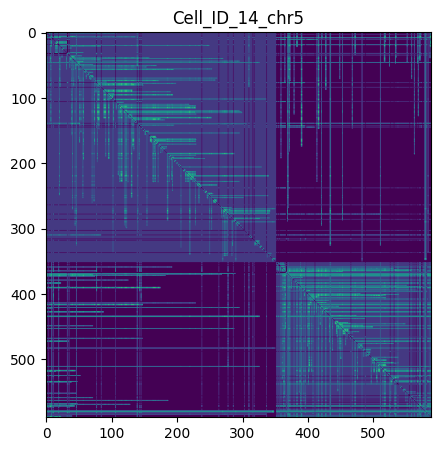

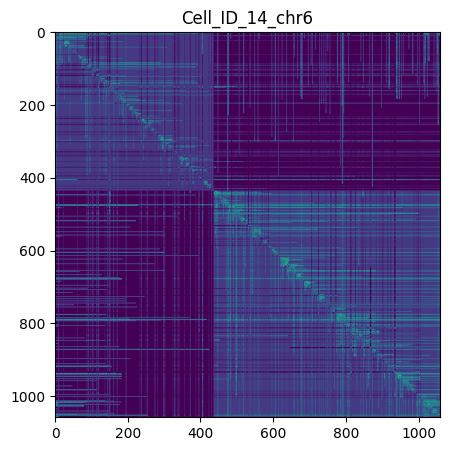

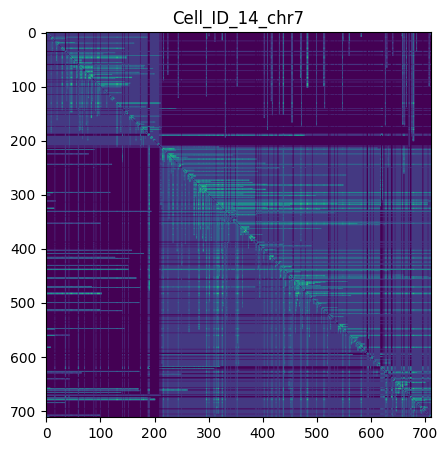

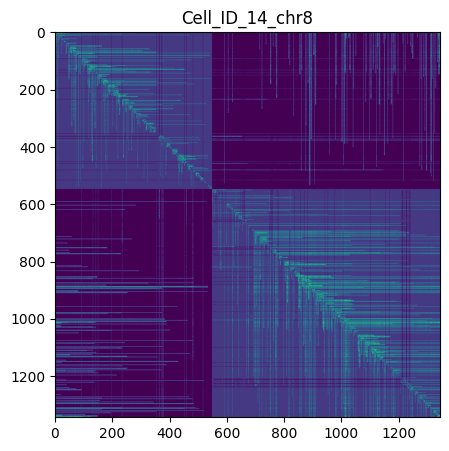

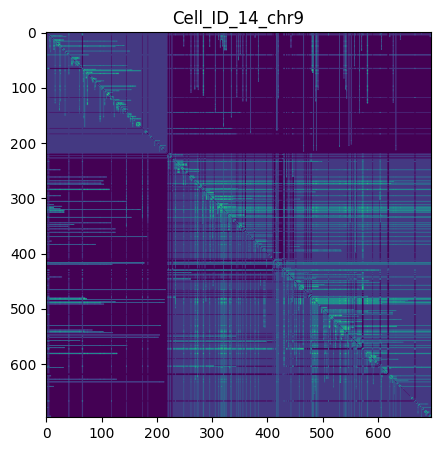

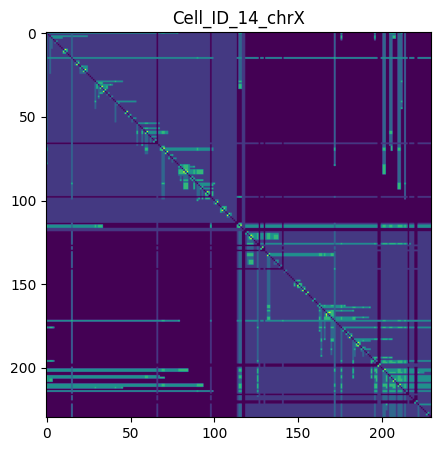

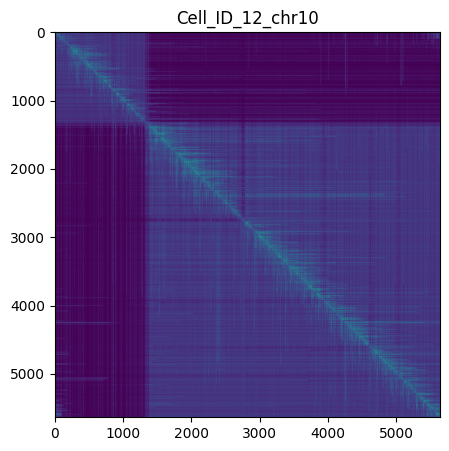

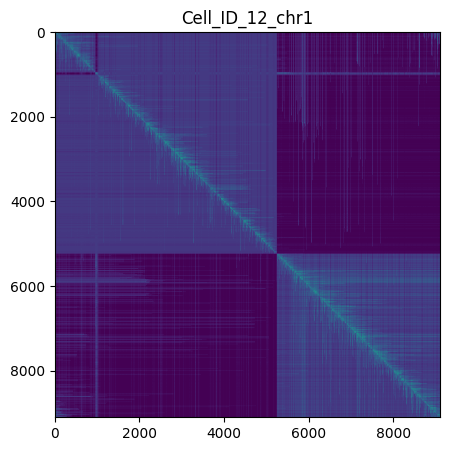

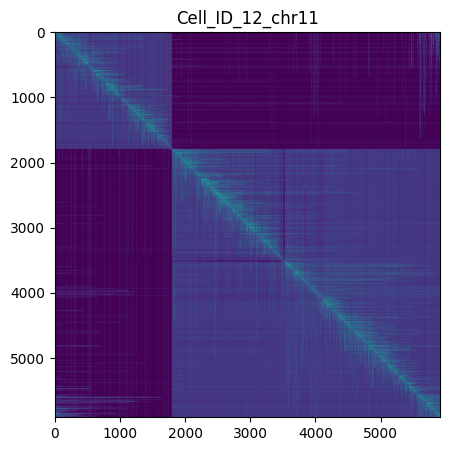

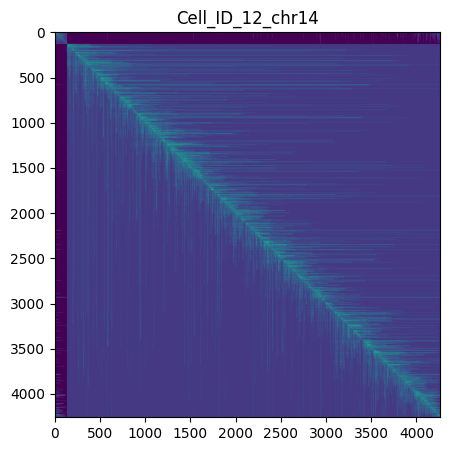

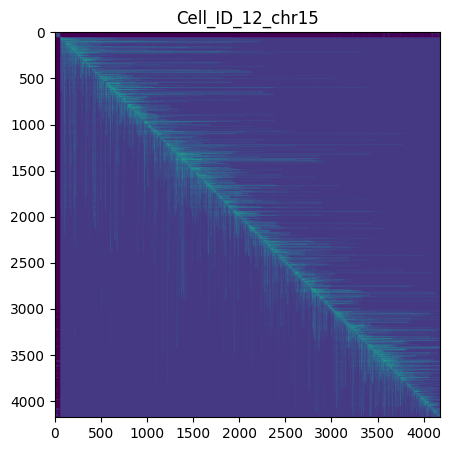

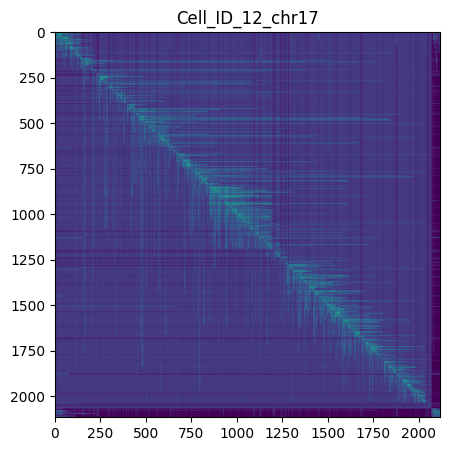

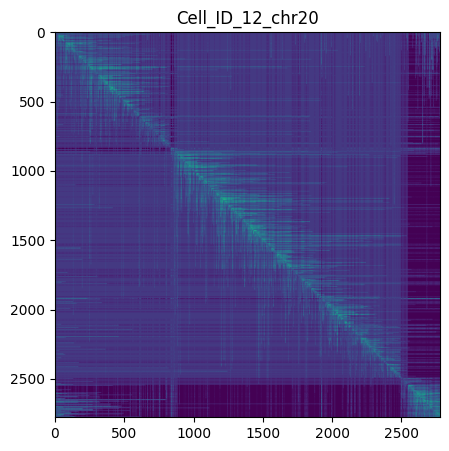

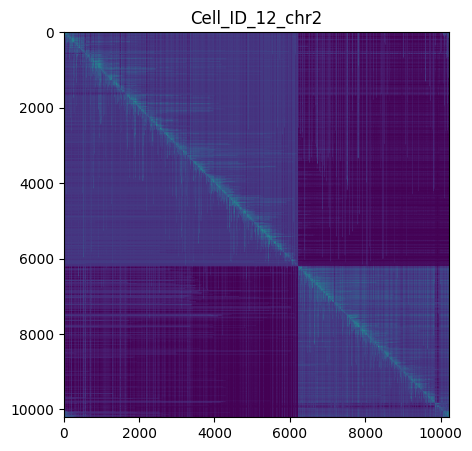

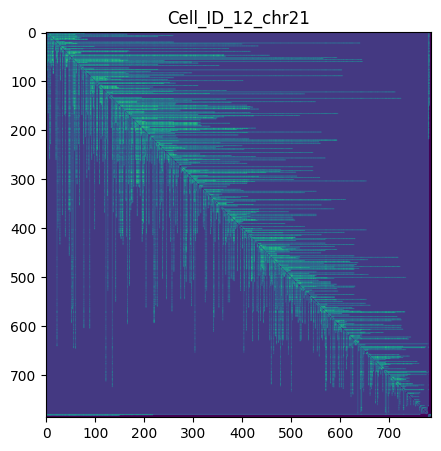

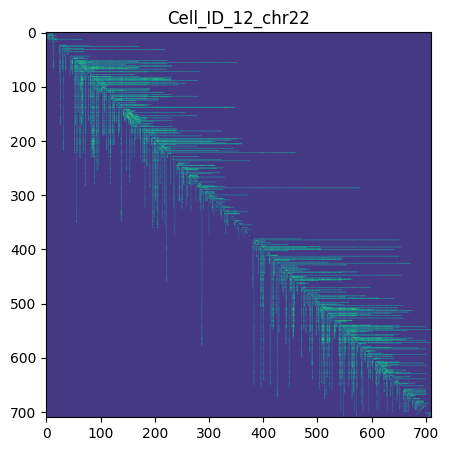

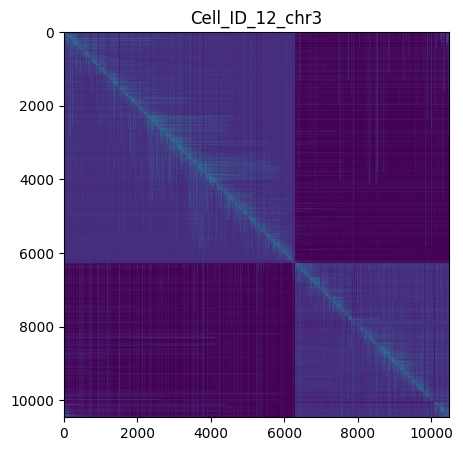

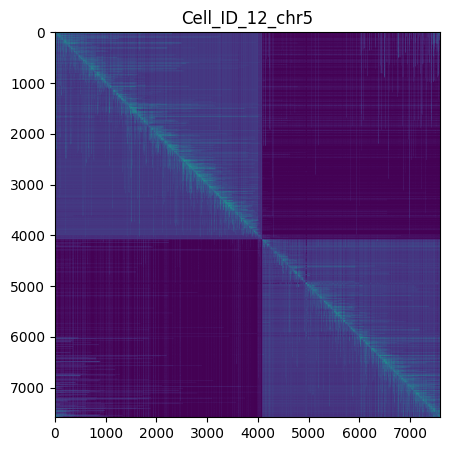

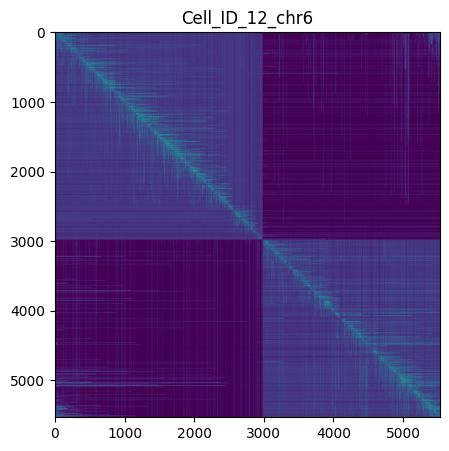

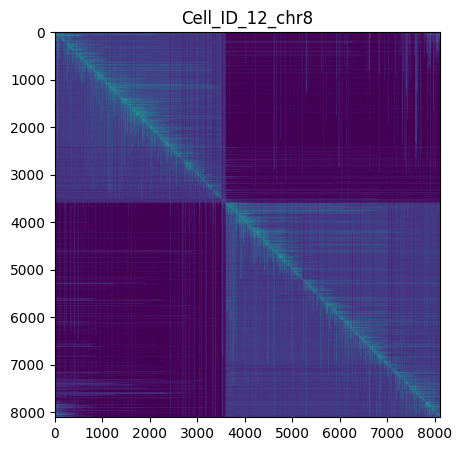

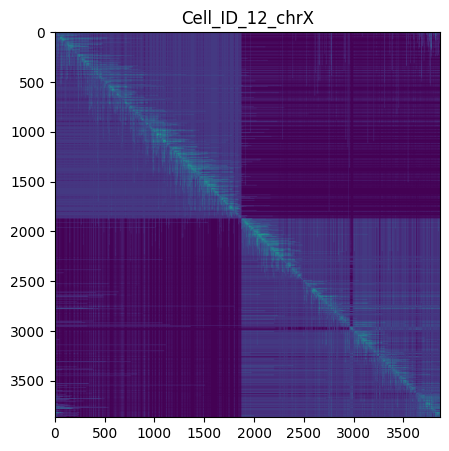

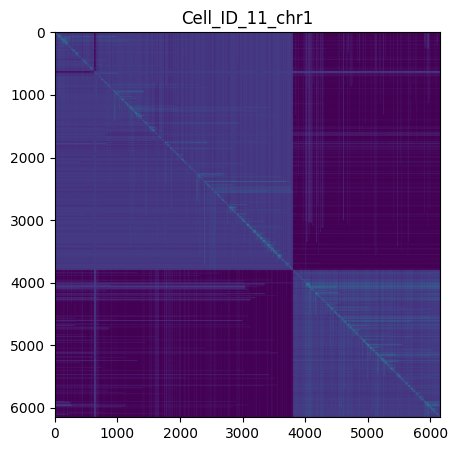

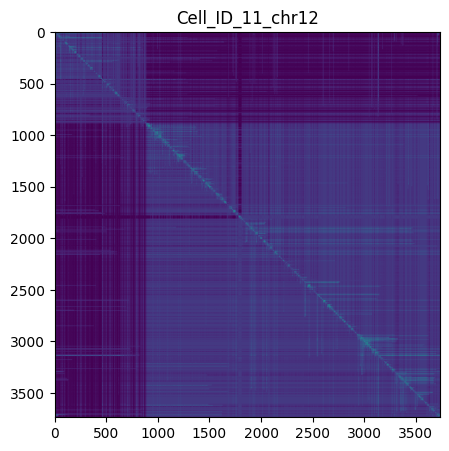

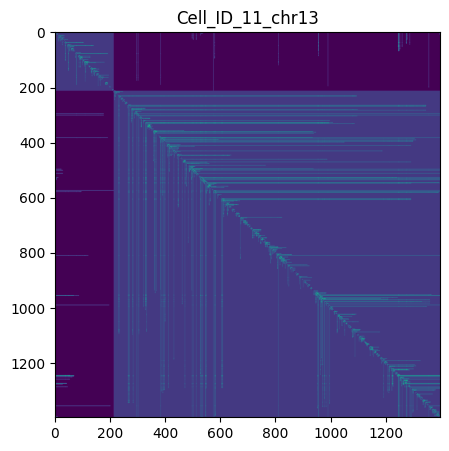

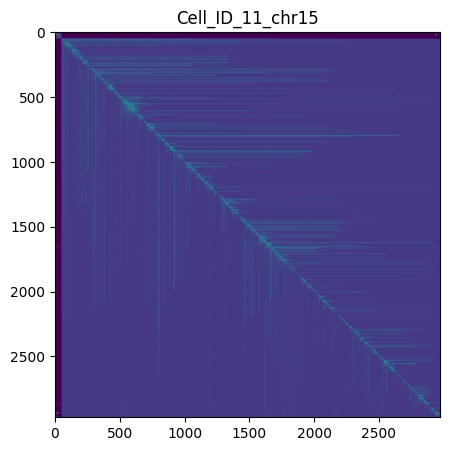

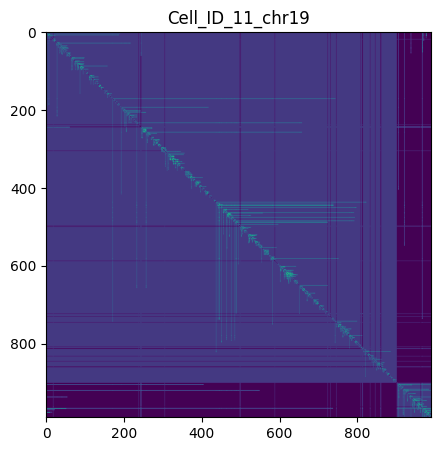

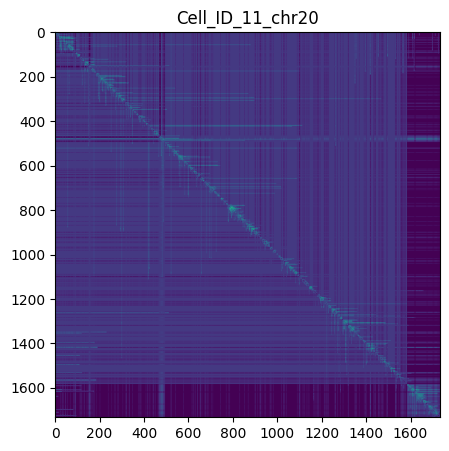

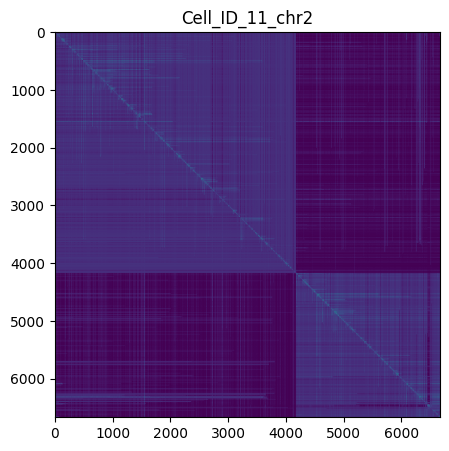

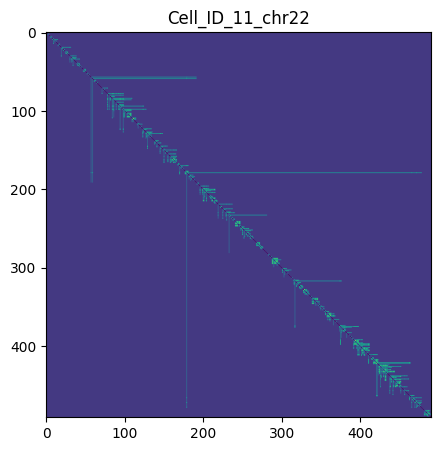

In [21]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import PIL
import matplotlib.pyplot as plt

data_dir = 'data'
file_names = [f for f in os.listdir(data_dir) if f.startswith('GSM') and f.endswith('.contact.txt')]
all_results = []

# Loop through file names
for file in file_names:
    print("Processing the", file[11:21])

    file_path = os.path.join(data_dir, file)

    # read data
    contacts = pd.read_csv(file_path, sep='\t')

    # extract cell ID
    cell = file[11:21]
    path_savematrix = 'results/matrices/{}'.format(cell)
    path_savedata = 'results/CT parameters'

    N_contacts = np.zeros(len(contacts['chr_A'].unique()))
    P = np.zeros(len(contacts['chr_A'].unique()))
    S = np.zeros(len(contacts['chr_A'].unique()))
    X = np.zeros(len(contacts['chr_A'].unique()))
    Dim_fractal = np.zeros(len(contacts['chr_A'].unique()))
    clustering = np.zeros(len(contacts['chr_A'].unique()))
    r2_fractalfit = np.zeros(len(contacts['chr_A'].unique()))

    # Loop through chromosomes for the current cell
    for t, chrom in enumerate(contacts['chr_A'].unique()):
        print("Processing chromosome", chrom)
        contacts_chr = contacts[(contacts['chr_A'] == chrom) & (contacts['chr_B'] == chrom)]
        index = [contacts_chr['pos_A'], contacts_chr['pos_B']]
        index = np.array(index)
        index = np.transpose(index)
        N_contacts[t] = len(index)

        mat, psc = get_matrix(index, chrom)
        P[t], S[t], X[t] = normalize_psc(psc, N_contacts[t])
        Dim_fractal[t], r2_fractalfit[t] = fractal_dimension(mat, plot_fig=0)
        G = make_graph(index)
        clustering[t] = nx.average_clustering(G)

        if plot_matrix:
            plt.figure(figsize=(5, 5))
            plt.imshow(mat)
            plt.title('{}_{}'.format(cell, chrom))


plt.show()

    #     if save_matrix:
    #         os.makedirs(path_savematrix, exist_ok=True)
    #         PIL.Image.fromarray(mat.astype(float)).save("{}/top_matrix_{}_{}.tif".format(path_savematrix, cell, chrom))
    #         plt.close()

    # # Save results for the current cell
    # if save_data:
    #     os.makedirs(path_savedata, exist_ok=True)
    #     topology_parameters = {
    #         'Parallel (%)': P,
    #         'Series (%)': S,
    #         'Cross (%)': X,
    #         'chromosome': contacts['chr_A'].unique(),
    #         'N contacts': N_contacts,
    #         'Fractal dimension': Dim_fractal,
    #         'r squared': r2_fractalfit,
    #         'Clustering': clustering
    #     }

    #     topology_parameters = pd.DataFrame(topology_parameters)
    #     topology_parameters.to_csv('{}/Top_parameters_{}.csv'.format(path_savedata, cell))

    #     # Create a DataFrame containing the sample name
    #     results_df = pd.DataFrame({
    #         'Sample': [cell] * len(contacts['chr_A'].unique()),  # Add a sample name column
    #         'chromosome': contacts['chr_A'].unique(),
    #         'Parallel (%)': P,
    #         'Series (%)': S,
    #         'Cross (%)': X,
    #         'N contacts': N_contacts,
    #         'Fractal dimension': Dim_fractal,
    #         'r squared': r2_fractalfit,
    #         'Clustering': clustering
    #     })

    #     all_results.append({
    #         'cell': cell,
    #         'topology_parameters': results_df
    #     })
